# Required libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# hana-ml classes
from hana_ml import ConnectionContext
from hana_ml.dataframe import create_dataframe_from_pandas, DataFrame
# Import outlier_detection_kmeans
from hana_ml.algorithms.pal.clustering import outlier_detection_kmeans

# --- Connection Setup (Replace with your actual credentials) ---
# Please ensure these environment variables are set or replace the strings directly.
hana_address = os.getenv('hana_address', "<your_hana_address>")
hana_port = int(os.getenv('hana_port', 443)) # Use int() for port
hana_user = os.getenv('hana_user', "<your_hana_user>")
hana_password = os.getenv('hana_password', "<your_hana_password>")
hana_encrypt = os.getenv('hana_encrypt', 'true').lower() == 'true' # Handle boolean conversion
hana_schema = os.getenv('HANA_SCHEMA', 'AICOE') # Default schema or your specific one

# Establish connection
try:
    cc = ConnectionContext(
        address=hana_address,
        port=hana_port,
        user=hana_user,
        password=hana_password,
        encrypt=hana_encrypt,
        # Add sslValidateCertificate='false' if using self-signed certs and encryption
        # sslValidateCertificate='false',
        current_schema=hana_schema # Set the schema context
    )
    print(f"HANA Connection Test Successful: {cc.hana_version()}")
    print(f"Current Schema: {cc.get_current_schema()}")
except Exception as e:
    print(f"Error connecting to HANA: {e}")
    # Stop execution if connection fails
    raise SystemExit("HANA connection failed, please check credentials and settings.")

# --- Configuration for the Notebook ---
# Name for the HANA table we will create
TABLE_NAME = "SYNTHETIC_ANOMALY_DATA_KMEANS_OD" # Changed table name
# Path to the generated data file
CSV_FILENAME = 'synthetic_anomaly_data.csv'
# Unique identifier column for HANA PAL functions
KEY_COL = 'ID'
# Ground truth column from the generator script
TRUTH_COL = 'is_anomaly'

ImportError: cannot import name 'display' from 'IPython.core.display' (/Users/I760054/Documents/programs/Best Practices/sap-btp-ai-best-practices/.venv/lib/python3.12/site-packages/IPython/core/display.py)


HANA Connection Test Successful: 4.00.000.00.1733217781 (fa/CE2024.28)
Current Schema: AICOE


# K-Means Outlier Detection with hana-ml

**Objective:** This notebook demonstrates how to use the `outlier_detection_kmeans` function provided by the SAP HANA Predictive Analysis Library (PAL) via the `hana-ml` Python client for anomaly detection on a synthetically generated dataset.

**Algorithm Overview:**

This method uses the K-Means clustering algorithm as a basis for outlier detection. The core idea is that outliers will typically be far away from the centroids (centers) of the clusters formed by the majority of the data. The function first performs K-Means clustering and then calculates a distance-based score for each point. Points with the highest scores (i.e., farthest from cluster centers, considering the specified distance metric and aggregation method) are flagged as outliers based on a specified contamination fraction or distance threshold.

**`hana_ml` Implementation:**

The `hana_ml.algorithms.pal.clustering.outlier_detection_kmeans` function (more documentation available [here](https://help.sap.com/doc/1d0ebfe5e8dd44d09606814d83308d4b/2.0.07/en-US/pal/algorithms/hana_ml.algorithms.pal.clustering.KMeansOutlier.html#hana_ml.algorithms.pal.clustering.KMeansOutlier)) provides an interface to the PAL K-Means outlier detection procedure. 

**Key Parameters (`outlier_detection_kmeans` function):**

*   `data` (DataFrame): Input HANA DataFrame.
*   `key` (str, optional): Name of the ID column.
*   `features` (list of str, optional): List of feature columns (must be numerical).
*   `n_clusters` (int, optional): Number of clusters for K-Means. If not specified, PAL uses G-means to determine the number.
*   `distance_level` (str, optional, default='euclidean'): Distance metric ('manhattan', 'euclidean', 'minkowski').
*   `contamination` (float, optional, default=0.1): Expected proportion of outliers in the data. Used to determine the number of outliers to return based on score ranking. Range (0, 1].
*   `sum_distance` (bool, optional, default=True): If True, the outlier score is the sum of distances to all cluster centers. If False, it's the distance to the assigned cluster's center.
*   `init` (str, optional, default='patent'): Initialization method for K-Means centers ('first_k', 'replace', 'no_replace', 'patent').
*   `max_iter` (int, optional, default=100): Maximum K-Means iterations.
*   `normalization` (str, optional, default='no'): Feature normalization ('no', 'l1_norm', 'min_max').
*   `tol` (float, optional, default=1e-9): K-Means convergence tolerance.
*   `distance_threshold` (float, optional, default=-1): An alternative to `contamination`. Points with a score *above* this threshold are considered outliers. If set (>=0), `contamination` might be ignored (check PAL docs for specifics).
*   `thread_number` (int, optional, default=1): Number of threads for execution.

**Return Values:**

The function returns a tuple of three HANA DataFrames:
1.  `outliers`: Contains the rows from the input `data` identified as outliers.
2.  `statistics`: Contains the ID, assigned cluster ID, and calculated outlier score for each detected outlier.
3.  `centers`: Contains the coordinates of the final cluster centers found by K-Means.

## 1. Data Loading and Preparation

Load the synthetic data and upload it to SAP HANA.

In [2]:
# Load data from CSV
try:
    df_local = pd.read_csv(CSV_FILENAME)
    print(f"Successfully loaded '{CSV_FILENAME}' with shape {df_local.shape}")
except FileNotFoundError:
    print(f"Error: The file '{CSV_FILENAME}' was not found.")
    print("Please run the 'anomaly_generator.py' script first to create the data.")
    # Stop execution
    raise SystemExit("Input data file not found.")

# Add a unique ID column required by many PAL functions
if KEY_COL not in df_local.columns:
    df_local.insert(0, KEY_COL, range(len(df_local)))
    print(f"Added unique '{KEY_COL}' column.")

# Identify feature columns (assuming they start with 'feature_')
feature_cols = [col for col in df_local.columns if col.startswith('feature_')]
if not feature_cols:
     raise ValueError("No columns starting with 'feature_' found. Check data generation script or naming.")
print(f"Identified Feature Columns: {feature_cols}")

# Display basic info and head of the local DataFrame
print("\nLocal DataFrame Info:")
df_local.info()
print("\nLocal DataFrame Head:")
print(df_local.head())
print("\nAnomaly Distribution (Ground Truth):")
print(df_local[TRUTH_COL].value_counts(normalize=True))

# Calculate the actual contamination level from the ground truth
# This will be used to set the 'contamination' parameter
actual_contamination = df_local[TRUTH_COL].mean()
# Ensure contamination is slightly above 0 if actual_contamination is 0
contamination_param = float(max(actual_contamination, 1e-6))
print(f"\nActual contamination in the dataset: {actual_contamination:.4f}")
print(f"Using contamination parameter: {contamination_param:.4f}")


# --- Upload data to HANA ---
# Drop the table if it exists before creating a new one
try:
    cc.drop_table(TABLE_NAME)
    print(f"Dropped existing table '{TABLE_NAME}' (if any).")
except Exception:
    print(f"Table '{TABLE_NAME}' does not exist yet, proceeding.")

# Create HANA DataFrame from pandas DataFrame
print(f"\nUploading data to HANA table '{TABLE_NAME}'...")
try:
    # Using force=True and replace=True ensures the table matches the pandas DF exactly
    hdf_input = create_dataframe_from_pandas(
        connection_context=cc,
        pandas_df=df_local,
        table_name=TABLE_NAME,
        force=True,
        replace=True,
        primary_key=KEY_COL # Setting primary key can improve performance
    )
    print(f"Successfully created HANA DataFrame: {hdf_input.select(KEY_COL).count()} rows.")
    # Display info about the HANA DataFrame
    print("\nHANA DataFrame Info (selected columns):")
    print(hdf_input.select(KEY_COL, TRUTH_COL, *feature_cols).head(5).collect())

except Exception as e:
    print(f"Error uploading data to HANA: {e}")
    raise SystemExit("Failed to create HANA DataFrame.")

Successfully loaded 'synthetic_anomaly_data.csv' with shape (1050, 6)
Added unique 'ID' column.
Identified Feature Columns: ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']

Local DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1050 non-null   int64  
 1   feature_1   1050 non-null   float64
 2   feature_2   1050 non-null   float64
 3   feature_3   1050 non-null   float64
 4   feature_4   1050 non-null   float64
 5   feature_5   1050 non-null   float64
 6   is_anomaly  1050 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 57.6 KB

Local DataFrame Head:
   ID  feature_1  feature_2  feature_3  feature_4  feature_5  is_anomaly
0   0  18.277572  48.592749  43.922557  42.893798  13.340332           0
1   1  22.595480  45.241644  34.772461  29.038658  15.248534           0
2   2  20.127974  4

ERROR:hana_ml.dataframe:Fail to drop table. (259, 'invalid table name: SYNTHETIC_ANOMALY_DATA_KMEANS_OD: line 1 col 20 (at pos 19)')


Dropped existing table 'SYNTHETIC_ANOMALY_DATA_KMEANS_OD' (if any).

Uploading data to HANA table 'SYNTHETIC_ANOMALY_DATA_KMEANS_OD'...


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


Successfully created HANA DataFrame: 1050 rows.

HANA DataFrame Info (selected columns):
   ID  is_anomaly  feature_1  feature_2  feature_3  feature_4  feature_5
0   0           0  18.277572  48.592749  43.922557  42.893798  13.340332
1   1           0  22.595480  45.241644  34.772461  29.038658  15.248534
2   2           0  20.127974  48.403411  23.545939  33.311360  -2.885488
3   3           0  16.412641  45.087063  47.438820  31.308031  26.548545
4   4           0  17.728823  47.785572  29.888634  17.650589  -1.527156


## 2. Running K-Means Outlier Detection

We call the `outlier_detection_kmeans` function directly, providing the input data and parameters. It performs clustering and outlier scoring in one step.

In [3]:
# Run the K-Means outlier detection function
print(f"\nRunning K-Means outlier detection with contamination = {contamination_param:.4f}...")

try:
    # Call the function
    outliers_hdf, stats_hdf, centers_hdf = outlier_detection_kmeans(
        data=hdf_input,
        key=KEY_COL,
        features=feature_cols,
        n_clusters=None, # Let PAL determine the number of clusters (G-means)
        distance_level='euclidean', # Default
        contamination=contamination_param,
        sum_distance=True, # Default
        # init='patent', # Default
        # max_iter=100, # Default
        # normalization='no', # Default
        # tol=1e-9, # Default
        # distance_threshold=-1, # Default (use contamination)
        thread_number=None # Let PAL decide
    )

    print("K-Means outlier detection completed.")

    # Check the results DataFrames
    if outliers_hdf:
        print(f"\nDetected {outliers_hdf.count()} outliers.")
        print("Detected Outliers (HANA DataFrame Head):")
        print(outliers_hdf.head(5).collect())
    else:
        print("\nNo outliers DataFrame returned.")

    if stats_hdf:
        print("\nOutlier Statistics (HANA DataFrame Head - ID, CLUSTER_ID, SCORE):")
        # Collect stats for evaluation
        df_stats = stats_hdf.collect()
        print(df_stats.head())

        
    else:
        print("\nNo statistics DataFrame returned.")

    if centers_hdf:
        print("\nCluster Centers (HANA DataFrame Head):")
        print(centers_hdf.head(5).collect())
    else:
        print("\nNo centers DataFrame returned.")

except Exception as e:
    print(f"Error during K-Means outlier detection: {e}")
    raise SystemExit("K-Means outlier detection failed.")


Running K-Means outlier detection with contamination = 0.0476...
K-Means outlier detection completed.

Detected 50 outliers.
Detected Outliers (HANA DataFrame Head):
    ID  feature_1  feature_2  feature_3  feature_4  feature_5
0  695   2.524688  56.936954 -38.118189 -22.536697 -47.001801
1  761  35.402529  59.844729 -33.409432  83.070363 -47.232258
2  933  36.648269  56.114021 -31.018769  76.648645  68.789108
3  195  31.831539  58.300103 -37.366261 -12.552601 -47.679779
4  951   2.939361  57.968931 -39.735283  60.467135 -44.481866

Outlier Statistics (HANA DataFrame Head - ID, CLUSTER_ID, SCORE):
    ID  CLUSTER_ID        SCORE
0  695           1  3773.885310
1  761           5  3681.108997
2  933           3  3629.622876
3  195           1  3614.249898
4  951           5  3492.126696

Cluster Centers (HANA DataFrame Head):
   CLUSTER_ID  feature_1  feature_2  feature_3  feature_4  feature_5
0           0  19.042221  47.867656  39.303837  31.423476   8.955175
1           1  19.419969

## 3. Evaluating the Results

Since the function only returns the *detected* outliers, we need to reconstruct the full prediction list to compare against the ground truth.

1.  Start with the original data (`df_local`).
2.  Create a `predicted_anomaly` column, initially all 0s (normal).
3.  Mark the rows whose IDs are present in the `df_stats` DataFrame as 1 (anomaly).
4.  Calculate metrics using the ground truth and the reconstructed `predicted_anomaly` column.
5.  Visualize the score distribution for the detected outliers.


Reconstructing full prediction list...

Local DataFrame Head (with truth and reconstructed prediction):
   ID  is_anomaly  predicted_anomaly
0   0           0                  0
1   1           0                  0
2   2           0                  0
3   3           0                  0
4   4           0                  0

Reconstructed Prediction Distribution:
predicted_anomaly
0    1000
1      50
Name: count, dtype: int64

--- Classification Report ---
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00      1000
 Anomaly (1)       1.00      1.00      1.00        50

    accuracy                           1.00      1050
   macro avg       1.00      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050


--- Confusion Matrix ---
[[1000    0]
 [   0   50]]


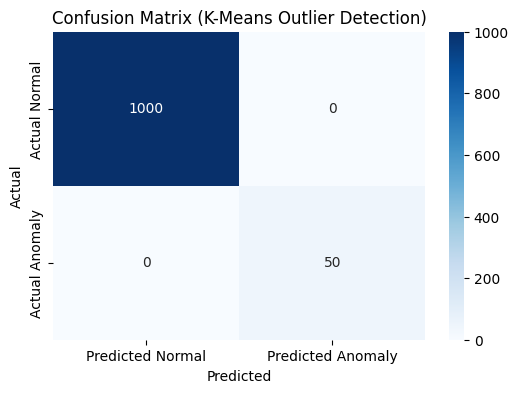

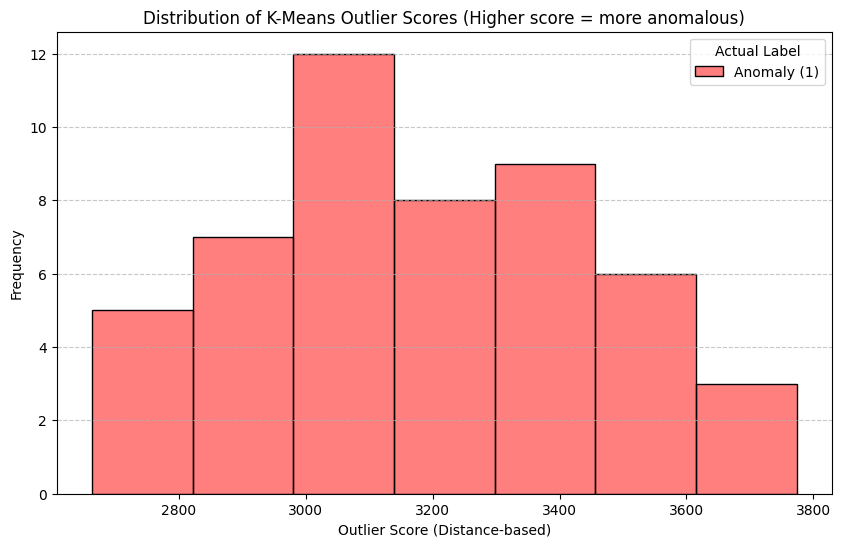


Note: Score distribution plot only shows scores for points detected as outliers.


In [4]:
# Ensure we have the statistics DataFrame
if 'df_stats' not in locals() or df_stats is None:
     raise SystemExit("Outlier statistics are not available for evaluation.")
if KEY_COL not in df_stats.columns:
     raise SystemExit(f"Required '{KEY_COL}' column not found in statistics results for evaluation.")

# Reconstruct the full prediction list
print("\nReconstructing full prediction list...")
# Start with assuming all points are normal (0)
df_local['predicted_anomaly'] = 0
# Get the IDs of the points flagged as outliers by the algorithm
outlier_ids = df_stats[KEY_COL].unique()
# Mark these points as anomalies (1) in our local dataframe
df_local.loc[df_local[KEY_COL].isin(outlier_ids), 'predicted_anomaly'] = 1

print("\nLocal DataFrame Head (with truth and reconstructed prediction):")
print(df_local[[KEY_COL, TRUTH_COL, 'predicted_anomaly']].head())
print("\nReconstructed Prediction Distribution:")
print(df_local['predicted_anomaly'].value_counts())

# --- Performance Metrics ---
print("\n--- Classification Report ---")
# Compare ground truth (is_anomaly) with the reconstructed prediction (predicted_anomaly)
print(classification_report(df_local[TRUTH_COL], df_local['predicted_anomaly'], target_names=['Normal (0)', 'Anomaly (1)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(df_local[TRUTH_COL], df_local['predicted_anomaly'])
print(cm)
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Normal', 'Predicted Anomaly'], yticklabels=['Actual Normal', 'Actual Anomaly'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (K-Means Outlier Detection)')
plt.show()


# --- Score Distribution ---
# Merge the original data (with truth) and the outlier stats (with scores)
# Use an outer join to keep all original points, scores will be NaN for non-outliers
df_merged_scores = pd.merge(df_local[[KEY_COL, TRUTH_COL]], df_stats[[KEY_COL, 'SCORE']], on=KEY_COL, how='left')

plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged_scores, x='SCORE', hue=TRUTH_COL, kde=False, palette={0: 'blue', 1: 'red'})
plt.title('Distribution of K-Means Outlier Scores (Higher score = more anomalous)')
plt.xlabel('Outlier Score (Distance-based)')
plt.ylabel('Frequency')
plt.legend(title='Actual Label', labels=['Anomaly (1)', 'Normal (0)']) # Adjust labels based on plot order if necessary
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nNote: Score distribution plot only shows scores for points detected as outliers.")


--- Visualizing Predictions vs. Ground Truth ---

Generating pair plot for prediction analysis...


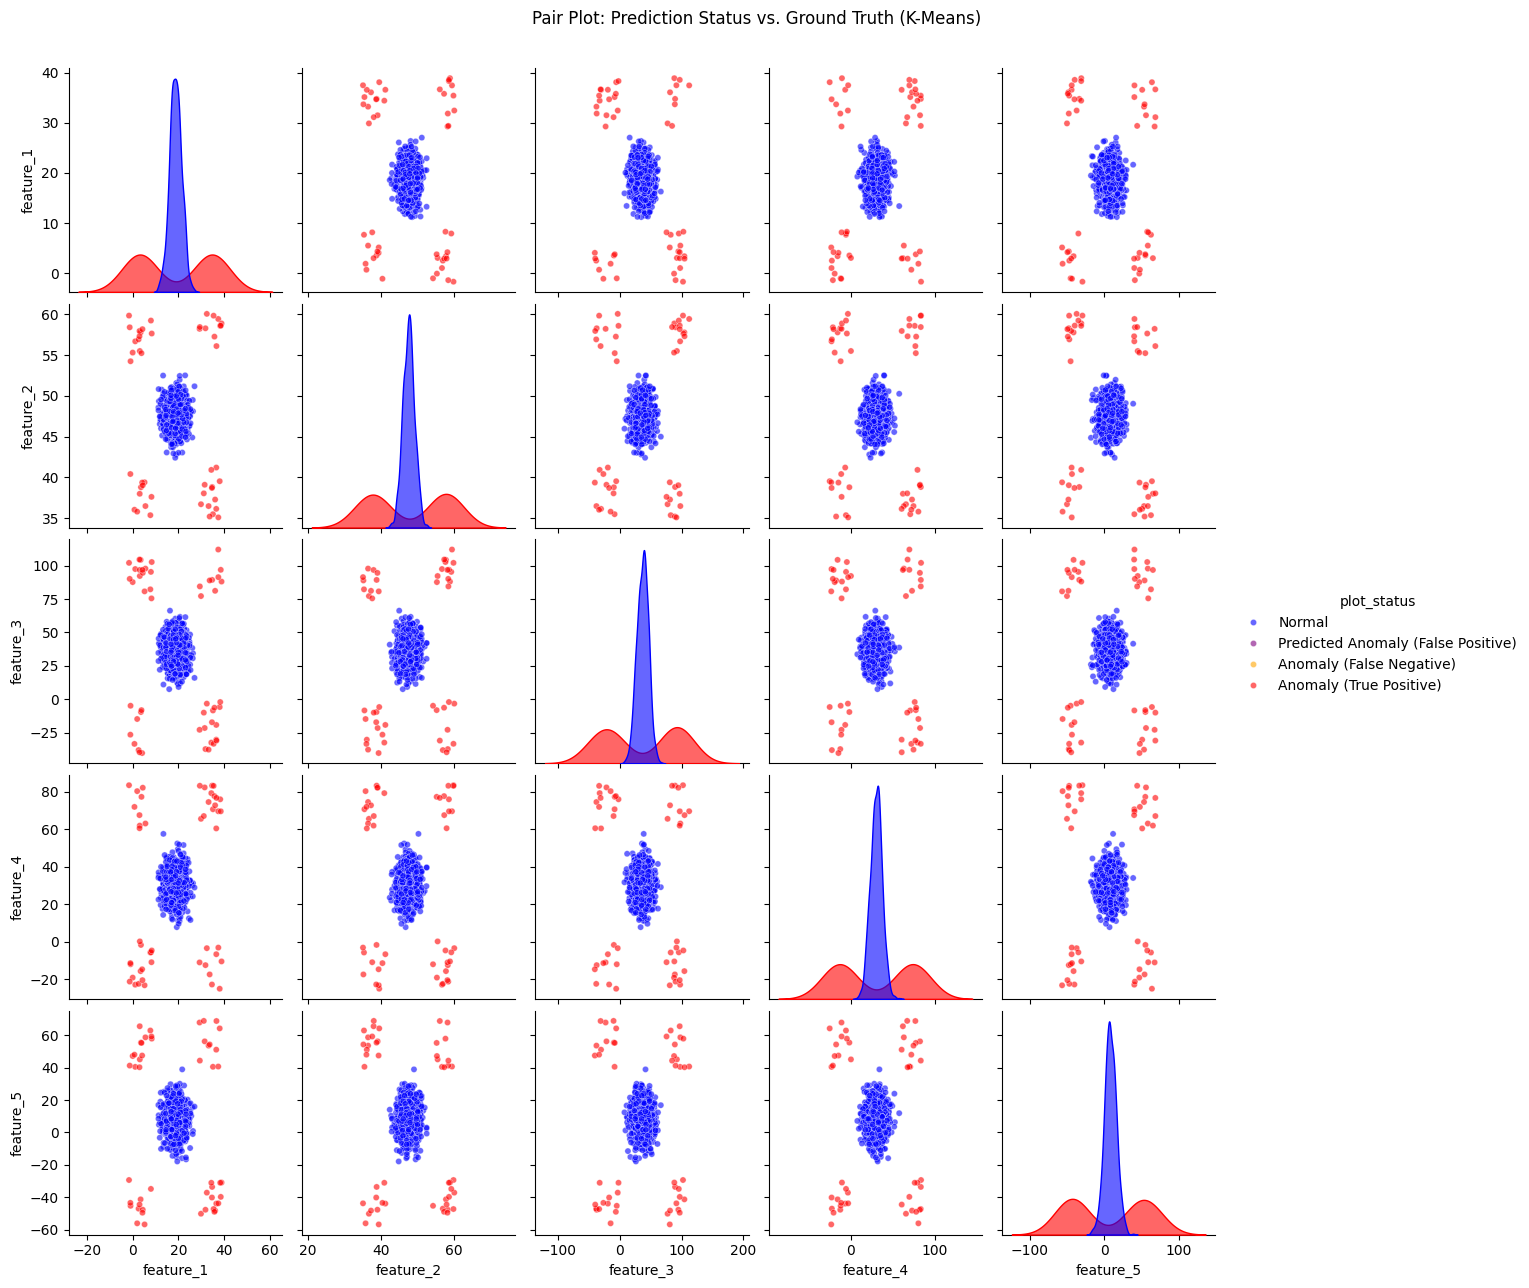

In [5]:
# --- Prediction Visualization (Pair Plot) ---
print("\n--- Visualizing Predictions vs. Ground Truth ---")

# Define a function to map status based on truth and prediction
def assign_plot_status(row):
    if row[TRUTH_COL] == 0 and row['predicted_anomaly'] == 0:
        return 'Normal'
    elif row[TRUTH_COL] == 1 and row['predicted_anomaly'] == 1:
        return 'Anomaly (True Positive)'
    elif row[TRUTH_COL] == 1 and row['predicted_anomaly'] == 0:
        return 'Anomaly (False Negative)' # Missed by model
    elif row[TRUTH_COL] == 0 and row['predicted_anomaly'] == 1:
        return 'Predicted Anomaly (False Positive)' # Incorrectly flagged
    else:
        return 'Unknown'

# Apply the function to create the status column in the local dataframe
# We use df_local because it contains predictions for all points (0 or 1)
df_local['plot_status'] = df_local.apply(assign_plot_status, axis=1)

# Define a color palette for the statuses
status_palette = {
    'Normal': 'blue',
    'Anomaly (True Positive)': 'red',
    'Anomaly (False Negative)': 'orange',
    'Predicted Anomaly (False Positive)': 'purple'
}

# Generate the pair plot
try:
    print("\nGenerating pair plot for prediction analysis...")
    # Use only feature columns for the plot axes
    pair_plot_preds = sns.pairplot(df_local, 
                                   vars=feature_cols, 
                                   hue='plot_status', 
                                   palette=status_palette,
                                   diag_kind='kde',
                                   plot_kws={'alpha': 0.6, 's': 20}, 
                                   diag_kws={'alpha': 0.6, 'common_norm': False}, # Use common_norm=False for KDE
                                   hue_order=['Normal', 'Predicted Anomaly (False Positive)', 'Anomaly (False Negative)', 'Anomaly (True Positive)'] # Control legend order
                                  )
    pair_plot_preds.fig.suptitle('Pair Plot: Prediction Status vs. Ground Truth (K-Means)', y=1.03) # Add title
    plt.show()
except Exception as e:
    print(f"\nCould not generate prediction pair plot. Error: {e}")

## 4. Cleanup

Finally, let's remove the table we created in HANA.

In [6]:
print("\n--- Cleaning up HANA tables ---")
tables_to_drop = [TABLE_NAME]

for table in tables_to_drop:
    try:
        cc.drop_table(table)
        print(f"Dropped table: {table}")
    except Exception as e:
        print(f"Could not drop table {table} (may not exist or permissions issue): {e}")

# Close the connection
try:
    cc.close()
    print("\nHANA connection closed.")
except Exception as e:
    print(f"Error closing connection: {e}")


--- Cleaning up HANA tables ---
Dropped table: SYNTHETIC_ANOMALY_DATA_KMEANS_OD

HANA connection closed.
